# 1️⃣ Introduction

## Emotion Classification Pipeline for Biblical Verses

This notebook documents the full process of exploring, comparing and fine-tuning emotion classification models on biblical text, with a focus on the Book of Genesis and a final fine-tuning using a custom-annotated corpus.

**Outline:**
1. Model Benchmarking on Genesis
2. Data Preparation for Fine-tuning
3. Semi-automatic Labeling using GPT-4o
4. Fine-tuning SamLowe/roberta-base-go_emotions
5. Evaluation and Comparison with Previous Models
6. Inference Examples and Analysis

---

**Project context:**  
Emotion and theme detection in Bible verses for narrative and literary research, using NLP and modern transformer models.


# 2️⃣ Benchmarking Pretrained Models on Genesis

## 1. Benchmarking Existing Models

We begin by testing several HuggingFace models (Hartmann, GoEmotions/SamLowe, Bhadresh Savani, Joeddav) on Genesis.  
The goal is to observe their behaviour on literary, ancient text before committing to any single approach.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/processed/bible_kjv/1_genesis_emotion_comparison.csv")
display(df.head())

# Plot emotion distributions
plt.figure()
sns.countplot(x="hartmann_label", data=df, order=df['hartmann_label'].value_counts().index)
plt.title("Hartmann Emotion Distribution")
plt.show()

plt.figure()
sns.countplot(x="goemotions_ekman_label", data=df, order=df['goemotions_ekman_label'].value_counts().index)
plt.title("GoEmotions (Ekman) Distribution")
plt.show()

plt.figure()
sns.countplot(x="bsavani_label", data=df, order=df['bsavani_label'].value_counts().index)
plt.title("Bhadresh Savani Emotion Distribution")
plt.show()

plt.figure()
sns.countplot(x="joeddav_ekman_label", data=df, order=df['joeddav_ekman_label'].value_counts().index)
plt.title("Joeddav (Ekman) Distribution")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '../data/processed/bible_kjv/1_genesis_emotion_comparison.csv'

### **Observations:**
- GoEmotions produces a strong "neutral" bias on Genesis.
- Hartmann and bsavani force more emotion categories, but may overfit to their social-media source.
- Joeddav shows a different distribution, with many "surprise" and "joy".
- None of the available models fit perfectly for literary or biblical style.


# 3️⃣ Preparing a Custom Dataset for Fine-tuning

## 2. Preparing a Custom Dataset for Fine-tuning

Given the above, we decided to build a custom, hand-verified emotion-labeled dataset, leveraging GPT-4o for fast annotation and manual review.
- 1000 unique verses were sampled from the full KJV.
- Each verse was labeled with one of: joy, sadness, anger, fear, disgust, surprise, neutral.


In [3]:
# Show sample of selected verses
df_samples = pd.read_csv("../data/evaluation/emotion_verses_to_label.csv")
display(df_samples.sample(5))
print(f"Total verses sampled: {len(df_samples)}")

,id,verse_id,verse
657,657,jeremiah_50_43,The king of Babylon hath heard the report of t...
488,488,deuteronomy_30_15,"See, I have set before thee this day life and ..."
520,520,luke_22_43,And there appeared an angel unto him from heav...
678,678,2_chronicles_2_1,And Solomon determined to build an house for t...
21,21,acts_11_18,"When they heard these things, they held their ..."


Total verses sampled: 1000


# 4️⃣ Labeling Verses with GPT-4o (Semi-automatic Annotation)

## 3. Semi-automatic Annotation using GPT-4o

Annotation prompt for GPT-4o:

> Assign ONE main human emotion to each Bible verse below.  
> Choose ONLY from this list: joy, sadness, anger, fear, disgust, surprise, neutral  
> Return in CSV format with columns: id,verse_id,label  
> [See appendix for full prompt.]

Labels were reviewed and corrected as needed before proceeding to fine-tuning.


,id,verse_id,verse,label
959,959,mark_1_12,And immediately the Spirit driveth him into th...,neutral
682,682,ezekiel_27_28,The suburbs shall shake at the sound of the cr...,fear
289,289,psalms_102_11,My days are like a shadow that declineth; and ...,sadness
786,786,genesis_31_11,"And the angel of God spake unto me in a dream,...",surprise
810,810,acts_9_24,But their laying await was known of Saul. And ...,fear


Total labeled verses: 1000


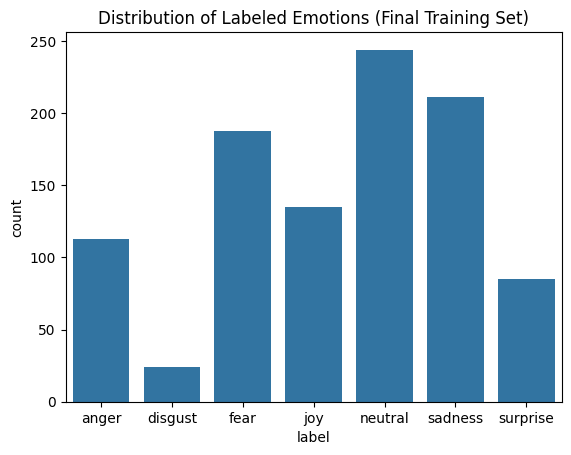

In [2]:
# Show labeled data (post-GPT + manual review)
df_labeled = pd.read_csv("../data/evaluation/emotion_verses_labeled_2.csv")
display(df_labeled.sample(5))
print(f"Total labeled verses: {len(df_labeled)}")

plt.figure()
sns.countplot(x="label", data=df_labeled, order=sorted(df_labeled['label'].unique()))
plt.title("Distribution of Labeled Emotions (Final Training Set)")
plt.show()

# 5️⃣ Fine-tuning SamLowe/roberta-base-go_emotions

## 4. Fine-tuning SamLowe/roberta-base-go_emotions on Custom Labeled Data

The fine-tuning uses 90% of the data for training and 10% for evaluation.  
Labels are mapped to integer IDs as required by HuggingFace.


We initialized the classification head (last layer) from scratch, as our label set consists of 7 mapped emotions, instead of the original 28 GoEmotions classes. The rest of the model loads all pre-trained weights, leveraging prior emotional knowledge. This is the recommended approach for transfer learning with a different output taxonomy.



In [6]:
# Si usas train/test como pandas DataFrame
print("Train:")
print(df_train['label'].value_counts())
print("\nTest:")
print(df_test['label'].value_counts())


Train:
label
6    799
0    543
1    371
2    311
3    303
4    166
5    109
Name: count, dtype: int64

Test:
label
6    80
0    49
1    46
3    41
2    36
4    24
5    14
Name: count, dtype: int64


### Cross validating

In [2]:
import pandas as pd
import os
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, EarlyStoppingCallback
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
import torch
import torch.nn.functional as F
from transformers import Trainer

# --- Compute class weights robustly ---
def compute_class_weights(df, label_column, class_labels):
    """
    Computes class weights for imbalanced classification.

    Args:
        df (pd.DataFrame): Training dataframe.
        label_column (str): Name of the label column.
        class_labels (list): List of all class integer labels, in model's order.

    Returns:
        torch.Tensor: Class weights as tensor, in order of class_labels.
    """
    counts = df[label_column].value_counts().reindex(class_labels, fill_value=0).values
    counts = np.maximum(counts, 1)  # Avoid division by zero
    weights = 1.0 / counts
    # No need to normalize: CrossEntropyLoss expects unnormalized weights
    weights_tensor = torch.tensor(weights, dtype=torch.float32)
    print("Class labels:", class_labels)
    print("Class counts:", counts)
    print("Class weights:", weights)
    return weights_tensor

def focal_loss(logits, labels, alpha=1.0, gamma=2.0, weight=None):
    """
    Compute focal loss for multi-class classification.
    Args:
        logits (Tensor): [batch_size, num_classes]
        labels (Tensor): [batch_size]
        alpha (float or Tensor, optional): Class weighting factor.
        gamma (float): Focusing parameter.
        weight (Tensor, optional): Class weights (as in CrossEntropyLoss).
    """
    ce_loss = F.cross_entropy(logits, labels, weight=weight, reduction='none')
    pt = torch.exp(-ce_loss)
    focal = (alpha * (1 - pt) ** gamma * ce_loss)
    return focal.mean()

class WeightedTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels", None)
        outputs = model(**inputs)
        logits = outputs.get("logits", None)
        if labels is not None and logits is not None:
            if not isinstance(labels, torch.Tensor):
                labels = torch.tensor(labels)
            labels = labels.to(logits.device).long()
            # Eliminar uso de weights, solo usar CrossEntropyLoss
            loss_fct = torch.nn.CrossEntropyLoss()  # Sin pesos de clase
            loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
            return (loss, outputs) if return_outputs else loss
        return (0.0, outputs) if return_outputs else 0.0


# --- 1. Load and shuffle data ---
df = pd.read_csv("../data/evaluation/verses_parsed/emotion_verses_labeled_combined.csv")
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

def clean_verse(text):
    import re
    # Quita saltos de línea, múltiples espacios, referencias tipo [1]
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\[\d+\]', '', text)
    text = text.strip()
    return text

df['verse'] = df['verse'].apply(clean_verse)

# --- 2. Mapping and validation ---
EMOTION_MAP = {
    "joy": "Alegría",
    "sadness": "Tristeza",
    "anger": "Ira",
    "fear": "Miedo",
    "surprise": "Sorpresa",
    "disgust": "Asco",
    "neutral": "Neutral"
}
label_list = list(EMOTION_MAP.keys())            # List of string labels, e.g. ['joy', 'sadness', ...]
label2id = {l: i for i, l in enumerate(label_list)}  # Mapping to int, order matches label_list
id2label = {i: l for i, l in enumerate(label_list)}
df['label'] = df['label'].str.strip().str.lower()
invalid_labels = set(df['label'].unique()) - set(label_list)
if invalid_labels:
    print(f"❌ ERROR: Detected invalid labels: {invalid_labels}")
    raise ValueError("Your CSV contains labels not present in the expected set.")
df['label'] = df['label'].map(label2id).astype(int)

# --- 3. Cross-validation setup ---
k = 5  # Number of folds
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
results = []
CV_OUTPUT_DIR = "./results_finetuned_bible_cv"
os.makedirs(CV_OUTPUT_DIR, exist_ok=True)

for fold, (train_idx, test_idx) in enumerate(skf.split(df['verse'], df['label'])):
    print(f"\n=== Fold {fold+1}/{k} ===")
    df_train, df_test = df.iloc[train_idx].copy(), df.iloc[test_idx].copy()

    # --- OPTIONAL OVERSAMPLING ---
    # max_n = df_train['label'].value_counts().max()
    # dfs = []
    # for label in df_train['label'].unique():
    #     df_label = df_train[df_train['label'] == label]
    #     dfs.append(resample(df_label, replace=True, n_samples=max_n, random_state=fold))
    # df_train = pd.concat(dfs).sample(frac=1, random_state=fold).reset_index(drop=True)
    # print("Balanced train label counts:\n", df_train['label'].value_counts())

    # --- Build datasets (renaming for HF compatibility) ---
    ds = DatasetDict({
        "train": Dataset.from_pandas(df_train[['verse', 'label']].rename(columns={'verse': 'text', 'label': 'labels'}), preserve_index=False),
        "test": Dataset.from_pandas(df_test[['verse', 'label']].rename(columns={'verse': 'text', 'label': 'labels'}), preserve_index=False),
    })

    # --- Tokenizer and model ---
    tokenizer = AutoTokenizer.from_pretrained("SamLowe/roberta-base-go_emotions")
    model = AutoModelForSequenceClassification.from_pretrained(
        "SamLowe/roberta-base-go_emotions",
        num_labels=len(label_list),
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True
    )
    model.config.problem_type = "single_label_classification"

    def preprocess_function(examples):
        return tokenizer(examples["text"], truncation=True, padding=True)

    tokenized_datasets = ds.map(preprocess_function, batched=True, remove_columns=["text"])

    # Define unique subfolder for this fold:
    fold_output_dir = os.path.join(CV_OUTPUT_DIR, f"fold_{fold+1}")

    # --- Training arguments ---
    training_args = TrainingArguments(
        output_dir=fold_output_dir,
        evaluation_strategy="epoch",
        learning_rate=1e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        gradient_accumulation_steps=1,
        num_train_epochs=4,
        weight_decay=0.05,
        warmup_ratio=0.1,
        lr_scheduler_type="linear",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="macro_f1",
        greater_is_better=True,
        save_total_limit=2,
        logging_strategy="no",
        report_to="none",
        seed=42 + fold,
        push_to_hub=False,
        disable_tqdm=True,
    )

    # --- Metrics ---
    def compute_metrics(pred):
        preds = np.argmax(pred.predictions, axis=1)
        labels = pred.label_ids
        report = classification_report(labels, preds, target_names=[id2label[i] for i in range(len(label_list))], output_dict=True, zero_division=0)
        macro_f1 = report["macro avg"]["f1-score"]
        print(f"\nFold {fold+1} - Macro F1: {macro_f1:.3f}")
        return {"macro_f1": macro_f1}

    # --- Trainer ---
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["test"],
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
    )

    trainer.train()
    metrics = trainer.evaluate()
    results.append(metrics)

# --- Show CV results ---
macro_f1s = [r["eval_macro_f1"] for r in results]
print(f"\n=== Cross-validation results ({k} folds) ===")
print(f"Macro F1 per fold: {macro_f1s}")
print(f"Mean Macro F1: {np.mean(macro_f1s):.3f} | Std: {np.std(macro_f1s):.3f}")


=== Fold 1/5 ===


c:\Users\manue\miniconda3\envs\LinguaAnimae\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([28]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([28, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 1951/1951 [00:00<00:00, 26083.22 examples/s]



Fold 1 - Macro F1: 0.455
{'eval_loss': 1.150935411453247, 'eval_macro_f1': 0.4548368585368057, 'eval_runtime': 12.9029, 'eval_samples_per_second': 151.206, 'eval_steps_per_second': 4.728, 'epoch': 1.0}

Fold 1 - Macro F1: 0.515
{'eval_loss': 1.0705690383911133, 'eval_macro_f1': 0.514635989591712, 'eval_runtime': 4.9489, 'eval_samples_per_second': 394.231, 'eval_steps_per_second': 12.326, 'epoch': 2.0}

Fold 1 - Macro F1: 0.537
{'eval_loss': 1.0767254829406738, 'eval_macro_f1': 0.5374697373946126, 'eval_runtime': 4.4595, 'eval_samples_per_second': 437.494, 'eval_steps_per_second': 13.679, 'epoch': 3.0}

Fold 1 - Macro F1: 0.537
{'eval_loss': 1.0771472454071045, 'eval_macro_f1': 0.5373530932247517, 'eval_runtime': 4.4784, 'eval_samples_per_second': 435.642, 'eval_steps_per_second': 13.621, 'epoch': 4.0}
{'train_runtime': 857.5282, 'train_samples_per_second': 36.384, 'train_steps_per_second': 2.276, 'train_loss': 1.0361291228747758, 'epoch': 4.0}

Fold 1 - Macro F1: 0.537
{'eval_loss': 1

c:\Users\manue\miniconda3\envs\LinguaAnimae\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([28]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([28, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 1950/1950 [00:00<00:00, 20252.86 examples/s]



Fold 2 - Macro F1: 0.436
{'eval_loss': 1.1780766248703003, 'eval_macro_f1': 0.43571469405472346, 'eval_runtime': 9.5669, 'eval_samples_per_second': 203.828, 'eval_steps_per_second': 6.376, 'epoch': 1.0}

Fold 2 - Macro F1: 0.503
{'eval_loss': 1.1164567470550537, 'eval_macro_f1': 0.5030821220285752, 'eval_runtime': 9.7374, 'eval_samples_per_second': 200.258, 'eval_steps_per_second': 6.264, 'epoch': 2.0}

Fold 2 - Macro F1: 0.537
{'eval_loss': 1.0923773050308228, 'eval_macro_f1': 0.5369503070964879, 'eval_runtime': 8.8644, 'eval_samples_per_second': 219.981, 'eval_steps_per_second': 6.881, 'epoch': 3.0}

Fold 2 - Macro F1: 0.535
{'eval_loss': 1.1012837886810303, 'eval_macro_f1': 0.5348441485849315, 'eval_runtime': 8.7083, 'eval_samples_per_second': 223.925, 'eval_steps_per_second': 7.005, 'epoch': 4.0}
{'train_runtime': 1331.4587, 'train_samples_per_second': 23.436, 'train_steps_per_second': 1.466, 'train_loss': 1.0434469004146387, 'epoch': 4.0}

Fold 2 - Macro F1: 0.537
{'eval_loss': 1

c:\Users\manue\miniconda3\envs\LinguaAnimae\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([28]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([28, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 1950/1950 [00:00<00:00, 23495.21 examples/s]



Fold 3 - Macro F1: 0.441
{'eval_loss': 1.141740322113037, 'eval_macro_f1': 0.4406317552118206, 'eval_runtime': 4.7469, 'eval_samples_per_second': 410.797, 'eval_steps_per_second': 12.851, 'epoch': 1.0}

Fold 3 - Macro F1: 0.525
{'eval_loss': 1.0721659660339355, 'eval_macro_f1': 0.5245043160778713, 'eval_runtime': 4.8342, 'eval_samples_per_second': 403.377, 'eval_steps_per_second': 12.618, 'epoch': 2.0}

Fold 3 - Macro F1: 0.542
{'eval_loss': 1.0595958232879639, 'eval_macro_f1': 0.5424518762569747, 'eval_runtime': 5.2367, 'eval_samples_per_second': 372.372, 'eval_steps_per_second': 11.649, 'epoch': 3.0}

Fold 3 - Macro F1: 0.548
{'eval_loss': 1.0727343559265137, 'eval_macro_f1': 0.5475306712384654, 'eval_runtime': 4.6887, 'eval_samples_per_second': 415.894, 'eval_steps_per_second': 13.01, 'epoch': 4.0}
{'train_runtime': 383.376, 'train_samples_per_second': 81.393, 'train_steps_per_second': 5.092, 'train_loss': 1.0362818358374424, 'epoch': 4.0}

Fold 3 - Macro F1: 0.548
{'eval_loss': 1.

c:\Users\manue\miniconda3\envs\LinguaAnimae\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([28]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([28, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 1950/1950 [00:00<00:00, 18206.63 examples/s]



Fold 4 - Macro F1: 0.460
{'eval_loss': 1.1730468273162842, 'eval_macro_f1': 0.46009078789469404, 'eval_runtime': 4.7817, 'eval_samples_per_second': 407.803, 'eval_steps_per_second': 12.757, 'epoch': 1.0}

Fold 4 - Macro F1: 0.493
{'eval_loss': 1.0949796438217163, 'eval_macro_f1': 0.49346073086316805, 'eval_runtime': 5.3409, 'eval_samples_per_second': 365.105, 'eval_steps_per_second': 11.421, 'epoch': 2.0}

Fold 4 - Macro F1: 0.514
{'eval_loss': 1.1051301956176758, 'eval_macro_f1': 0.5141432585888426, 'eval_runtime': 4.9573, 'eval_samples_per_second': 393.355, 'eval_steps_per_second': 12.305, 'epoch': 3.0}

Fold 4 - Macro F1: 0.526
{'eval_loss': 1.1184967756271362, 'eval_macro_f1': 0.5258538493232302, 'eval_runtime': 5.2544, 'eval_samples_per_second': 371.117, 'eval_steps_per_second': 11.609, 'epoch': 4.0}
{'train_runtime': 349.689, 'train_samples_per_second': 89.234, 'train_steps_per_second': 5.582, 'train_loss': 1.0572143304543418, 'epoch': 4.0}

Fold 4 - Macro F1: 0.526
{'eval_loss'

c:\Users\manue\miniconda3\envs\LinguaAnimae\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([28]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([28, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 1950/1950 [00:00<00:00, 20845.27 examples/s]



Fold 5 - Macro F1: 0.467
{'eval_loss': 1.1310807466506958, 'eval_macro_f1': 0.4669228333580676, 'eval_runtime': 4.2174, 'eval_samples_per_second': 462.367, 'eval_steps_per_second': 14.464, 'epoch': 1.0}

Fold 5 - Macro F1: 0.492
{'eval_loss': 1.0873554944992065, 'eval_macro_f1': 0.49154670686068497, 'eval_runtime': 4.1873, 'eval_samples_per_second': 465.697, 'eval_steps_per_second': 14.568, 'epoch': 2.0}

Fold 5 - Macro F1: 0.515
{'eval_loss': 1.0825508832931519, 'eval_macro_f1': 0.514564323977504, 'eval_runtime': 4.2836, 'eval_samples_per_second': 455.221, 'eval_steps_per_second': 14.24, 'epoch': 3.0}

Fold 5 - Macro F1: 0.515
{'eval_loss': 1.074852466583252, 'eval_macro_f1': 0.5152446739562164, 'eval_runtime': 4.4125, 'eval_samples_per_second': 441.925, 'eval_steps_per_second': 13.824, 'epoch': 4.0}
{'train_runtime': 360.0521, 'train_samples_per_second': 86.665, 'train_steps_per_second': 5.421, 'train_loss': 1.0426089177366162, 'epoch': 4.0}

Fold 5 - Macro F1: 0.515
{'eval_loss': 1

### Train model

In [1]:
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, EarlyStoppingCallback
import numpy as np
from sklearn.metrics import classification_report
import torch
import torch.nn.functional as F
from transformers import Trainer
import optuna

# 1. Load and shuffle data
df = pd.read_csv("../data/evaluation/verses_parsed/emotion_verses_labeled_combined.csv")
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# 2. Mapping and validation
EMOTION_MAP = {
    "joy": "Alegría",
    "sadness": "Tristeza",
    "anger": "Ira",
    "fear": "Miedo",
    "surprise": "Sorpresa",
    "disgust": "Asco",
    "neutral": "Neutral"
}
label_list = list(EMOTION_MAP.keys())
label2id = {l: i for i, l in enumerate(label_list)}
id2label = {i: l for i, l in enumerate(label_list)}
df['label'] = df['label'].str.strip().str.lower()
invalid_labels = set(df['label'].unique()) - set(label_list)
if invalid_labels:
    print(f"❌ ERROR: Detected invalid labels: {invalid_labels}")
    raise ValueError("Your CSV contains labels not present in the expected set.")
df['label'] = df['label'].map(label2id).astype(int)

# 3. Split into train/test
split = int(len(df) * 0.9)
df_train = df.iloc[:split].copy()
df_test = df.iloc[split:].copy()


# 5. Build datasets
df_train['label'] = df_train['label'].astype(int)
df_test['label'] = df_test['label'].astype(int)
ds = DatasetDict({
    "train": Dataset.from_pandas(df_train[['verse', 'label']].rename(columns={'verse': 'text', 'label': 'labels'}), preserve_index=False),
    "test": Dataset.from_pandas(df_test[['verse', 'label']].rename(columns={'verse': 'text', 'label': 'labels'}), preserve_index=False),
})

# 6. Tokenizer
tokenizer = AutoTokenizer.from_pretrained("SamLowe/roberta-base-go_emotions")

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True)

tokenized_datasets = ds.map(preprocess_function, batched=True, remove_columns=["text"])

# 7. Custom WeightedTrainer

def focal_loss(logits, labels, alpha=1.0, gamma=2.0, weight=None):
    """
    Compute focal loss for multi-class classification.
    Args:
        logits (Tensor): [batch_size, num_classes]
        labels (Tensor): [batch_size]
        alpha (float or Tensor, optional): Class weighting factor.
        gamma (float): Focusing parameter.
        weight (Tensor, optional): Class weights (as in CrossEntropyLoss).
    """
    ce_loss = F.cross_entropy(logits, labels, weight=weight, reduction='none')
    pt = torch.exp(-ce_loss)
    focal = (alpha * (1 - pt) ** gamma * ce_loss)
    return focal.mean()

class WeightedTrainer(Trainer):
    def __init__(self, *args, weights=None, alpha=1.0, gamma=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.gamma = gamma

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels", None)
        outputs = model(**inputs)
        logits = outputs.get("logits", None)
        if labels is not None and logits is not None:
            if not isinstance(labels, torch.Tensor):
                labels = torch.tensor(labels)
            labels = labels.to(logits.device).long()
            # Usamos CrossEntropyLoss sin pesos
            loss_fct = torch.nn.CrossEntropyLoss()  # Sin weights
            loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
            return (loss, outputs) if return_outputs else loss
        return (0.0, outputs) if return_outputs else 0.0



# 8. Metrics
def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    labels = pred.label_ids
    report = classification_report(labels, preds, target_names=[id2label[i] for i in range(len(label_list))], output_dict=True, zero_division=0)
    macro_f1 = report["macro avg"]["f1-score"]
    return {"macro_f1": macro_f1}

# 9. Model init for Optuna (returns a fresh model for each trial)
def model_init():
    model = AutoModelForSequenceClassification.from_pretrained(
        "SamLowe/roberta-base-go_emotions",
        num_labels=len(label_list),
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True
    )
    model.config.problem_type = "single_label_classification"  # <-- Aquí
    return model

# 10. Define Optuna search space
def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 5e-6, 5e-5, log=True),  # Actualizado
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
        "weight_decay": trial.suggest_float("weight_decay", 0.01, 0.2),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 2, 6),
        "warmup_ratio": trial.suggest_float("warmup_ratio", 0.05, 0.3),
        "gamma": trial.suggest_float("gamma", 1.5, 3.5), 
        "alpha": trial.suggest_float("alpha", 0.8, 1.2), 
    }

# 11. TrainingArguments (defaults, will be overridden by Optuna per trial)
training_args = TrainingArguments(
    output_dir="./results_finetuned_bible_optuna",
    evaluation_strategy="epoch",
    lr_scheduler_type="linear",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    save_total_limit=2,
    logging_strategy="no",
    report_to="none",
    seed=42,
    push_to_hub=False,
    disable_tqdm=True,
)

# 12. Trainer
trainer = WeightedTrainer(
    model_init=model_init,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)],
)

# 13. Run Optuna hyperparameter search
best_run = trainer.hyperparameter_search(
    direction="maximize",
    n_trials=20, 
    hp_space=optuna_hp_space
)

print(f"Best trial: {best_run}")

# 14. Train final model with best hyperparameters
for key, value in best_run.hyperparameters.items():
    setattr(trainer.args, key, value)
    if key == "alpha":
        trainer.alpha = value
    if key == "gamma":
        trainer.gamma = value

trainer.train()
trainer.save_model("../src/fine_tuning/finetuned-goemotions-bible-optuna")

c:\Users\manue\miniconda3\envs\LinguaAnimae\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\manue\miniconda3\envs\LinguaAnimae\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Map: 100%|██████████| 976/976 [00:00<00:00, 29575.55 examples/s]
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([28]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Si

{'eval_loss': 1.153934359550476, 'eval_macro_f1': 0.44391327172288503, 'eval_runtime': 2.1458, 'eval_samples_per_second': 454.843, 'eval_steps_per_second': 56.855, 'epoch': 1.0}
{'eval_loss': 1.049004316329956, 'eval_macro_f1': 0.5077304143566147, 'eval_runtime': 2.1895, 'eval_samples_per_second': 445.758, 'eval_steps_per_second': 55.72, 'epoch': 2.0}
{'eval_loss': 1.0716345310211182, 'eval_macro_f1': 0.5315036798739128, 'eval_runtime': 2.0108, 'eval_samples_per_second': 485.368, 'eval_steps_per_second': 60.671, 'epoch': 3.0}
{'eval_loss': 1.084185242652893, 'eval_macro_f1': 0.5398692464969373, 'eval_runtime': 1.992, 'eval_samples_per_second': 489.952, 'eval_steps_per_second': 61.244, 'epoch': 4.0}
{'eval_loss': 1.1194475889205933, 'eval_macro_f1': 0.5406556710965333, 'eval_runtime': 1.9276, 'eval_samples_per_second': 506.336, 'eval_steps_per_second': 63.292, 'epoch': 5.0}


[I 2025-05-22 23:36:53,955] Trial 0 finished with value: 0.5406556710965333 and parameters: {'learning_rate': 1.6560964730246075e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.16496172735944575, 'num_train_epochs': 5, 'warmup_ratio': 0.12206773879748896, 'gamma': 3.0947809303523464, 'alpha': 0.8500357080525651}. Best is trial 0 with value: 0.5406556710965333.
Trying to set gamma in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set alpha in the hyperparameter search but there is no corresponding field in `TrainingArguments`.


{'train_runtime': 379.0472, 'train_samples_per_second': 115.751, 'train_steps_per_second': 3.628, 'train_loss': 0.949353515625, 'epoch': 5.0}


c:\Users\manue\miniconda3\envs\LinguaAnimae\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([28]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([28, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.2337744235992432, 'eval_macro_f1': 0.386367749136275, 'eval_runtime': 1.9261, 'eval_samples_per_second': 506.71, 'eval_steps_per_second': 63.339, 'epoch': 1.0}
{'eval_loss': 1.1250355243682861, 'eval_macro_f1': 0.44745996254409065, 'eval_runtime': 2.2606, 'eval_samples_per_second': 431.736, 'eval_steps_per_second': 53.967, 'epoch': 2.0}
{'eval_loss': 1.0821396112442017, 'eval_macro_f1': 0.4950272244355017, 'eval_runtime': 1.9331, 'eval_samples_per_second': 504.88, 'eval_steps_per_second': 63.11, 'epoch': 3.0}
{'eval_loss': 1.0723201036453247, 'eval_macro_f1': 0.5080069833780952, 'eval_runtime': 1.9229, 'eval_samples_per_second': 507.56, 'eval_steps_per_second': 63.445, 'epoch': 4.0}
{'eval_loss': 1.074013590812683, 'eval_macro_f1': 0.5032313620846124, 'eval_runtime': 1.9477, 'eval_samples_per_second': 501.117, 'eval_steps_per_second': 62.64, 'epoch': 5.0}


[I 2025-05-22 23:43:10,598] Trial 1 finished with value: 0.5032313620846124 and parameters: {'learning_rate': 7.446659702105853e-06, 'per_device_train_batch_size': 32, 'weight_decay': 0.17995129031213478, 'num_train_epochs': 5, 'warmup_ratio': 0.10803100587054272, 'gamma': 1.9941768709142853, 'alpha': 1.0251104193872338}. Best is trial 0 with value: 0.5406556710965333.
Trying to set gamma in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set alpha in the hyperparameter search but there is no corresponding field in `TrainingArguments`.


{'train_runtime': 375.5322, 'train_samples_per_second': 116.834, 'train_steps_per_second': 3.661, 'train_loss': 1.113274591619318, 'epoch': 5.0}


c:\Users\manue\miniconda3\envs\LinguaAnimae\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([28]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([28, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.132463812828064, 'eval_macro_f1': 0.45244138948061063, 'eval_runtime': 1.9607, 'eval_samples_per_second': 497.791, 'eval_steps_per_second': 62.224, 'epoch': 1.0}
{'eval_loss': 1.0476115942001343, 'eval_macro_f1': 0.5202146881547375, 'eval_runtime': 1.9619, 'eval_samples_per_second': 497.476, 'eval_steps_per_second': 62.185, 'epoch': 2.0}
{'eval_loss': 1.0793198347091675, 'eval_macro_f1': 0.5252289977023892, 'eval_runtime': 2.0248, 'eval_samples_per_second': 482.028, 'eval_steps_per_second': 60.253, 'epoch': 3.0}


[I 2025-05-22 23:47:28,580] Trial 2 finished with value: 0.5252289977023892 and parameters: {'learning_rate': 1.758929535934372e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.052334241760782135, 'num_train_epochs': 3, 'warmup_ratio': 0.18137192522012074, 'gamma': 1.9648258280703064, 'alpha': 1.1655285219192395}. Best is trial 0 with value: 0.5406556710965333.
Trying to set gamma in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set alpha in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
c:\Users\manue\miniconda3\envs\LinguaAnimae\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'train_runtime': 256.9077, 'train_samples_per_second': 102.469, 'train_steps_per_second': 6.411, 'train_loss': 1.0506939404504403, 'epoch': 3.0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([28]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([28, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.3140078783035278, 'eval_macro_f1': 0.37184806662981085, 'eval_runtime': 2.1864, 'eval_samples_per_second': 446.4, 'eval_steps_per_second': 55.8, 'epoch': 1.0}
{'eval_loss': 1.1659495830535889, 'eval_macro_f1': 0.4182549553480496, 'eval_runtime': 1.9353, 'eval_samples_per_second': 504.327, 'eval_steps_per_second': 63.041, 'epoch': 2.0}
{'eval_loss': 1.1206947565078735, 'eval_macro_f1': 0.4484515592756028, 'eval_runtime': 1.9819, 'eval_samples_per_second': 492.446, 'eval_steps_per_second': 61.556, 'epoch': 3.0}
{'eval_loss': 1.1123558282852173, 'eval_macro_f1': 0.4541191773339664, 'eval_runtime': 2.0116, 'eval_samples_per_second': 485.185, 'eval_steps_per_second': 60.648, 'epoch': 4.0}


[I 2025-05-22 23:52:30,592] Trial 3 finished with value: 0.4541191773339664 and parameters: {'learning_rate': 5.690886872757119e-06, 'per_device_train_batch_size': 32, 'weight_decay': 0.07723270770616796, 'num_train_epochs': 4, 'warmup_ratio': 0.24849485556838707, 'gamma': 2.3862183012644467, 'alpha': 1.1448942908849347}. Best is trial 0 with value: 0.5406556710965333.
Trying to set gamma in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set alpha in the hyperparameter search but there is no corresponding field in `TrainingArguments`.


{'train_runtime': 300.697, 'train_samples_per_second': 116.729, 'train_steps_per_second': 3.658, 'train_loss': 1.2585398171164772, 'epoch': 4.0}


c:\Users\manue\miniconda3\envs\LinguaAnimae\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([28]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([28, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.1645578145980835, 'eval_macro_f1': 0.4243940805417026, 'eval_runtime': 2.0207, 'eval_samples_per_second': 482.996, 'eval_steps_per_second': 60.375, 'epoch': 1.0}
{'eval_loss': 1.089882254600525, 'eval_macro_f1': 0.4588352003988985, 'eval_runtime': 2.1528, 'eval_samples_per_second': 453.367, 'eval_steps_per_second': 56.671, 'epoch': 2.0}
{'eval_loss': 1.0917409658432007, 'eval_macro_f1': 0.48196674621147123, 'eval_runtime': 1.936, 'eval_samples_per_second': 504.124, 'eval_steps_per_second': 63.015, 'epoch': 3.0}


[I 2025-05-22 23:57:01,449] Trial 4 finished with value: 0.48196674621147123 and parameters: {'learning_rate': 7.345069575543386e-06, 'per_device_train_batch_size': 16, 'weight_decay': 0.045387279540569134, 'num_train_epochs': 3, 'warmup_ratio': 0.07382889161777294, 'gamma': 2.842237200419467, 'alpha': 0.8249079016461736}. Best is trial 0 with value: 0.5406556710965333.
Trying to set gamma in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set alpha in the hyperparameter search but there is no corresponding field in `TrainingArguments`.


{'train_runtime': 269.4679, 'train_samples_per_second': 97.693, 'train_steps_per_second': 6.112, 'train_loss': 1.1568966687775122, 'epoch': 3.0}


c:\Users\manue\miniconda3\envs\LinguaAnimae\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([28]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([28, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.1306653022766113, 'eval_macro_f1': 0.44411948428859954, 'eval_runtime': 1.9405, 'eval_samples_per_second': 502.959, 'eval_steps_per_second': 62.87, 'epoch': 1.0}
{'eval_loss': 1.0524274110794067, 'eval_macro_f1': 0.5156273679009232, 'eval_runtime': 2.0809, 'eval_samples_per_second': 469.038, 'eval_steps_per_second': 58.63, 'epoch': 2.0}
{'eval_loss': 1.0725390911102295, 'eval_macro_f1': 0.5365432662997608, 'eval_runtime': 2.0765, 'eval_samples_per_second': 470.014, 'eval_steps_per_second': 58.752, 'epoch': 3.0}
{'eval_loss': 1.1100733280181885, 'eval_macro_f1': 0.5579396571928269, 'eval_runtime': 2.0064, 'eval_samples_per_second': 486.434, 'eval_steps_per_second': 60.804, 'epoch': 4.0}


[I 2025-05-23 00:02:58,471] Trial 5 finished with value: 0.5579396571928269 and parameters: {'learning_rate': 1.4859438402215026e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.09179916879381364, 'num_train_epochs': 4, 'warmup_ratio': 0.11700669070517074, 'gamma': 2.0827319414213106, 'alpha': 0.9773781214422633}. Best is trial 5 with value: 0.5579396571928269.
Trying to set gamma in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set alpha in the hyperparameter search but there is no corresponding field in `TrainingArguments`.


{'train_runtime': 355.9966, 'train_samples_per_second': 98.596, 'train_steps_per_second': 6.169, 'train_loss': 0.9638399495887409, 'epoch': 4.0}


c:\Users\manue\miniconda3\envs\LinguaAnimae\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([28]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([28, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.119063138961792, 'eval_macro_f1': 0.45566613668106504, 'eval_runtime': 2.0048, 'eval_samples_per_second': 486.835, 'eval_steps_per_second': 60.854, 'epoch': 1.0}
{'eval_loss': 1.044901728630066, 'eval_macro_f1': 0.5327960493938663, 'eval_runtime': 2.0051, 'eval_samples_per_second': 486.767, 'eval_steps_per_second': 60.846, 'epoch': 2.0}
{'eval_loss': 1.1295243501663208, 'eval_macro_f1': 0.52873476421961, 'eval_runtime': 2.0097, 'eval_samples_per_second': 485.636, 'eval_steps_per_second': 60.705, 'epoch': 3.0}


[I 2025-05-23 00:07:25,429] Trial 6 finished with value: 0.52873476421961 and parameters: {'learning_rate': 2.52138803868877e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.09267665560578589, 'num_train_epochs': 5, 'warmup_ratio': 0.1328240236839583, 'gamma': 3.1885291459567116, 'alpha': 0.9974145139453552}. Best is trial 5 with value: 0.5579396571928269.
Trying to set gamma in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set alpha in the hyperparameter search but there is no corresponding field in `TrainingArguments`.


{'train_runtime': 265.918, 'train_samples_per_second': 164.994, 'train_steps_per_second': 10.323, 'train_loss': 1.0257054730191257, 'epoch': 3.0}


c:\Users\manue\miniconda3\envs\LinguaAnimae\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([28]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([28, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.0924794673919678, 'eval_macro_f1': 0.4690632856763562, 'eval_runtime': 1.9949, 'eval_samples_per_second': 489.253, 'eval_steps_per_second': 61.157, 'epoch': 1.0}
{'eval_loss': 1.0349279642105103, 'eval_macro_f1': 0.5388244025217929, 'eval_runtime': 2.0476, 'eval_samples_per_second': 476.654, 'eval_steps_per_second': 59.582, 'epoch': 2.0}


[I 2025-05-23 00:10:23,593] Trial 7 finished with value: 0.5388244025217929 and parameters: {'learning_rate': 2.4799124720966066e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.022281555707266205, 'num_train_epochs': 2, 'warmup_ratio': 0.06778440999349795, 'gamma': 2.9814841187970487, 'alpha': 0.8491363281684018}. Best is trial 5 with value: 0.5579396571928269.
Trying to set gamma in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set alpha in the hyperparameter search but there is no corresponding field in `TrainingArguments`.


{'train_runtime': 177.0978, 'train_samples_per_second': 99.098, 'train_steps_per_second': 6.2, 'train_loss': 1.0937086428449454, 'epoch': 2.0}


c:\Users\manue\miniconda3\envs\LinguaAnimae\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([28]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([28, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.1547048091888428, 'eval_macro_f1': 0.4287924687817392, 'eval_runtime': 1.9404, 'eval_samples_per_second': 502.984, 'eval_steps_per_second': 62.873, 'epoch': 1.0}
{'eval_loss': 1.0540410280227661, 'eval_macro_f1': 0.506494448660187, 'eval_runtime': 2.0551, 'eval_samples_per_second': 474.906, 'eval_steps_per_second': 59.363, 'epoch': 2.0}
{'eval_loss': 1.0655736923217773, 'eval_macro_f1': 0.5209376632802624, 'eval_runtime': 2.0701, 'eval_samples_per_second': 471.482, 'eval_steps_per_second': 58.935, 'epoch': 3.0}
{'eval_loss': 1.090766429901123, 'eval_macro_f1': 0.5413630153517894, 'eval_runtime': 1.9674, 'eval_samples_per_second': 496.096, 'eval_steps_per_second': 62.012, 'epoch': 4.0}
{'eval_loss': 1.1541903018951416, 'eval_macro_f1': 0.550032209857327, 'eval_runtime': 1.9641, 'eval_samples_per_second': 496.923, 'eval_steps_per_second': 62.115, 'epoch': 5.0}
{'eval_loss': 1.1727772951126099, 'eval_macro_f1': 0.552115240975587, 'eval_runtime': 1.9333, 'eval_samples_per_s

[I 2025-05-23 00:17:59,638] Trial 8 finished with value: 0.552115240975587 and parameters: {'learning_rate': 1.6997893346781543e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.03407414759043114, 'num_train_epochs': 6, 'warmup_ratio': 0.12150033350687926, 'gamma': 2.6691818617092564, 'alpha': 1.0877386871798462}. Best is trial 5 with value: 0.5579396571928269.
Trying to set gamma in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set alpha in the hyperparameter search but there is no corresponding field in `TrainingArguments`.


{'train_runtime': 454.9951, 'train_samples_per_second': 115.716, 'train_steps_per_second': 3.626, 'train_loss': 0.8673211854876894, 'epoch': 6.0}


c:\Users\manue\miniconda3\envs\LinguaAnimae\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([28]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([28, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.1178783178329468, 'eval_macro_f1': 0.4912314617890319, 'eval_runtime': 1.9512, 'eval_samples_per_second': 500.196, 'eval_steps_per_second': 62.525, 'epoch': 1.0}
{'eval_loss': 1.0233469009399414, 'eval_macro_f1': 0.5347917593734616, 'eval_runtime': 1.9527, 'eval_samples_per_second': 499.815, 'eval_steps_per_second': 62.477, 'epoch': 2.0}
{'eval_loss': 1.0689940452575684, 'eval_macro_f1': 0.5428064528540648, 'eval_runtime': 1.9599, 'eval_samples_per_second': 497.988, 'eval_steps_per_second': 62.249, 'epoch': 3.0}


[I 2025-05-23 00:21:42,287] Trial 9 finished with value: 0.5428064528540648 and parameters: {'learning_rate': 3.352284036261166e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.10181379543053024, 'num_train_epochs': 3, 'warmup_ratio': 0.2868836875685784, 'gamma': 2.1945296415844204, 'alpha': 0.8904692704131193}. Best is trial 5 with value: 0.5579396571928269.
Trying to set gamma in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set alpha in the hyperparameter search but there is no corresponding field in `TrainingArguments`.


{'train_runtime': 221.5308, 'train_samples_per_second': 118.832, 'train_steps_per_second': 3.724, 'train_loss': 1.0498687559185607, 'epoch': 3.0}


c:\Users\manue\miniconda3\envs\LinguaAnimae\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([28]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([28, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.155316710472107, 'eval_macro_f1': 0.4556099134976141, 'eval_runtime': 2.0518, 'eval_samples_per_second': 475.67, 'eval_steps_per_second': 59.459, 'epoch': 1.0}
{'eval_loss': 1.071487307548523, 'eval_macro_f1': 0.5232643774203684, 'eval_runtime': 1.9895, 'eval_samples_per_second': 490.575, 'eval_steps_per_second': 61.322, 'epoch': 2.0}
{'eval_loss': 1.0856424570083618, 'eval_macro_f1': 0.5331632538907539, 'eval_runtime': 2.0043, 'eval_samples_per_second': 486.955, 'eval_steps_per_second': 60.869, 'epoch': 3.0}
{'eval_loss': 1.1297625303268433, 'eval_macro_f1': 0.5422462030865562, 'eval_runtime': 1.9962, 'eval_samples_per_second': 488.931, 'eval_steps_per_second': 61.116, 'epoch': 4.0}


[I 2025-05-23 00:29:35,332] Trial 10 finished with value: 0.5422462030865562 and parameters: {'learning_rate': 1.0414048521445648e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.1388971779838564, 'num_train_epochs': 4, 'warmup_ratio': 0.20254504044329677, 'gamma': 1.5044207398463671, 'alpha': 0.9418024933164245}. Best is trial 5 with value: 0.5579396571928269.
Trying to set gamma in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set alpha in the hyperparameter search but there is no corresponding field in `TrainingArguments`.


{'train_runtime': 471.5797, 'train_samples_per_second': 74.431, 'train_steps_per_second': 9.305, 'train_loss': 1.0013402140781678, 'epoch': 4.0}


c:\Users\manue\miniconda3\envs\LinguaAnimae\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([28]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([28, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.1624293327331543, 'eval_macro_f1': 0.45849100305893026, 'eval_runtime': 1.9945, 'eval_samples_per_second': 489.357, 'eval_steps_per_second': 61.17, 'epoch': 1.0}
{'eval_loss': 1.0770434141159058, 'eval_macro_f1': 0.5277946812625071, 'eval_runtime': 1.9906, 'eval_samples_per_second': 490.307, 'eval_steps_per_second': 61.288, 'epoch': 2.0}
{'eval_loss': 1.0743008852005005, 'eval_macro_f1': 0.5517973734018137, 'eval_runtime': 1.9319, 'eval_samples_per_second': 505.193, 'eval_steps_per_second': 63.149, 'epoch': 3.0}
{'eval_loss': 1.2131503820419312, 'eval_macro_f1': 0.5425752305709518, 'eval_runtime': 1.9317, 'eval_samples_per_second': 505.248, 'eval_steps_per_second': 63.156, 'epoch': 4.0}


[I 2025-05-23 00:37:17,018] Trial 11 finished with value: 0.5425752305709518 and parameters: {'learning_rate': 1.2623889636755666e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.016194407302142555, 'num_train_epochs': 6, 'warmup_ratio': 0.1608414371633636, 'gamma': 2.6355173373909233, 'alpha': 1.0801361355058683}. Best is trial 5 with value: 0.5579396571928269.
Trying to set gamma in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set alpha in the hyperparameter search but there is no corresponding field in `TrainingArguments`.


{'train_runtime': 460.3414, 'train_samples_per_second': 114.372, 'train_steps_per_second': 14.298, 'train_loss': 0.9790434094049111, 'epoch': 4.0}


c:\Users\manue\miniconda3\envs\LinguaAnimae\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([28]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([28, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.1121466159820557, 'eval_macro_f1': 0.4881039521501224, 'eval_runtime': 1.9418, 'eval_samples_per_second': 502.633, 'eval_steps_per_second': 62.829, 'epoch': 1.0}
{'eval_loss': 1.037827730178833, 'eval_macro_f1': 0.5414690580010444, 'eval_runtime': 2.0371, 'eval_samples_per_second': 479.104, 'eval_steps_per_second': 59.888, 'epoch': 2.0}
{'eval_loss': 1.1146098375320435, 'eval_macro_f1': 0.5597329182858488, 'eval_runtime': 2.0188, 'eval_samples_per_second': 483.454, 'eval_steps_per_second': 60.432, 'epoch': 3.0}
{'eval_loss': 1.216984510421753, 'eval_macro_f1': 0.5223879304982966, 'eval_runtime': 2.016, 'eval_samples_per_second': 484.118, 'eval_steps_per_second': 60.515, 'epoch': 4.0}


[I 2025-05-23 00:42:20,507] Trial 12 finished with value: 0.5223879304982966 and parameters: {'learning_rate': 4.5727504843803065e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.130511363933912, 'num_train_epochs': 6, 'warmup_ratio': 0.09976364410299624, 'gamma': 3.4223169883081113, 'alpha': 1.0807760072406436}. Best is trial 5 with value: 0.5579396571928269.
Trying to set gamma in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set alpha in the hyperparameter search but there is no corresponding field in `TrainingArguments`.


{'train_runtime': 302.4202, 'train_samples_per_second': 174.096, 'train_steps_per_second': 5.456, 'train_loss': 0.8672415438565341, 'epoch': 4.0}


c:\Users\manue\miniconda3\envs\LinguaAnimae\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([28]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([28, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-23 00:43:48,652] Trial 13 pruned. 
Trying to set gamma in the hyperparameter search but there is no corresponding field in `Tra

{'eval_loss': 1.1491388082504272, 'eval_macro_f1': 0.42198920237616916, 'eval_runtime': 2.0068, 'eval_samples_per_second': 486.355, 'eval_steps_per_second': 60.794, 'epoch': 1.0}


c:\Users\manue\miniconda3\envs\LinguaAnimae\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([28]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([28, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-23 00:45:46,319] Trial 14 pruned. 
Trying to set gamma in the hyperparameter search but there is no corresponding field in `Tra

{'eval_loss': 1.25123131275177, 'eval_macro_f1': 0.44382785113827566, 'eval_runtime': 1.9985, 'eval_samples_per_second': 488.369, 'eval_steps_per_second': 61.046, 'epoch': 1.0}


c:\Users\manue\miniconda3\envs\LinguaAnimae\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([28]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([28, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.1316993236541748, 'eval_macro_f1': 0.45557366478623457, 'eval_runtime': 1.9974, 'eval_samples_per_second': 488.633, 'eval_steps_per_second': 61.079, 'epoch': 1.0}
{'eval_loss': 1.0414968729019165, 'eval_macro_f1': 0.5320871543687261, 'eval_runtime': 2.0039, 'eval_samples_per_second': 487.051, 'eval_steps_per_second': 60.881, 'epoch': 2.0}
{'eval_loss': 1.09615159034729, 'eval_macro_f1': 0.5346290691159894, 'eval_runtime': 2.0114, 'eval_samples_per_second': 485.223, 'eval_steps_per_second': 60.653, 'epoch': 3.0}


[I 2025-05-23 00:51:36,814] Trial 15 pruned. 
Trying to set gamma in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set alpha in the hyperparameter search but there is no corresponding field in `TrainingArguments`.


{'eval_loss': 1.1487911939620972, 'eval_macro_f1': 0.5359735837398466, 'eval_runtime': 1.9371, 'eval_samples_per_second': 503.844, 'eval_steps_per_second': 62.981, 'epoch': 4.0}


c:\Users\manue\miniconda3\envs\LinguaAnimae\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([28]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([28, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-23 00:52:49,436] Trial 16 pruned. 
Trying to set gamma in the hyperparameter search but there is no corresponding field in `Tra

{'eval_loss': 1.2013399600982666, 'eval_macro_f1': 0.4008580053814591, 'eval_runtime': 1.9507, 'eval_samples_per_second': 500.341, 'eval_steps_per_second': 62.543, 'epoch': 1.0}


c:\Users\manue\miniconda3\envs\LinguaAnimae\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([28]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([28, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-23 00:54:02,267] Trial 17 pruned. 
Trying to set gamma in the hyperparameter search but there is no corresponding field in `Tra

{'eval_loss': 1.1546036005020142, 'eval_macro_f1': 0.43231667154205194, 'eval_runtime': 1.9508, 'eval_samples_per_second': 500.301, 'eval_steps_per_second': 62.538, 'epoch': 1.0}


c:\Users\manue\miniconda3\envs\LinguaAnimae\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([28]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([28, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.1326216459274292, 'eval_macro_f1': 0.46317605469997564, 'eval_runtime': 1.9545, 'eval_samples_per_second': 499.366, 'eval_steps_per_second': 62.421, 'epoch': 1.0}
{'eval_loss': 1.0346910953521729, 'eval_macro_f1': 0.5353011828792998, 'eval_runtime': 1.9437, 'eval_samples_per_second': 502.14, 'eval_steps_per_second': 62.767, 'epoch': 2.0}
{'eval_loss': 1.09611177444458, 'eval_macro_f1': 0.5381201240741416, 'eval_runtime': 1.9486, 'eval_samples_per_second': 500.861, 'eval_steps_per_second': 62.608, 'epoch': 3.0}
{'eval_loss': 1.1498173475265503, 'eval_macro_f1': 0.560008628376455, 'eval_runtime': 1.9568, 'eval_samples_per_second': 498.775, 'eval_steps_per_second': 62.347, 'epoch': 4.0}


[I 2025-05-23 00:59:40,085] Trial 18 finished with value: 0.560008628376455 and parameters: {'learning_rate': 2.0997719890677325e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.06767372213238981, 'num_train_epochs': 4, 'warmup_ratio': 0.17678706270920386, 'gamma': 2.328271620594925, 'alpha': 1.1221181393625204}. Best is trial 18 with value: 0.560008628376455.
Trying to set gamma in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set alpha in the hyperparameter search but there is no corresponding field in `TrainingArguments`.


{'train_runtime': 336.7261, 'train_samples_per_second': 104.239, 'train_steps_per_second': 6.522, 'train_loss': 0.9224688420530225, 'epoch': 4.0}


c:\Users\manue\miniconda3\envs\LinguaAnimae\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([28]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([28, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.200172781944275, 'eval_macro_f1': 0.4583378944602635, 'eval_runtime': 1.9971, 'eval_samples_per_second': 488.7, 'eval_steps_per_second': 61.088, 'epoch': 1.0}
{'eval_loss': 1.1198277473449707, 'eval_macro_f1': 0.5364590407825842, 'eval_runtime': 1.9412, 'eval_samples_per_second': 502.77, 'eval_steps_per_second': 62.846, 'epoch': 2.0}
{'eval_loss': 1.1473878622055054, 'eval_macro_f1': 0.5516849751044562, 'eval_runtime': 1.942, 'eval_samples_per_second': 502.58, 'eval_steps_per_second': 62.822, 'epoch': 3.0}


[I 2025-05-23 01:05:17,307] Trial 19 pruned. 


{'eval_loss': 1.2953791618347168, 'eval_macro_f1': 0.5502548761693579, 'eval_runtime': 1.9497, 'eval_samples_per_second': 500.589, 'eval_steps_per_second': 62.574, 'epoch': 4.0}
Best trial: BestRun(run_id='18', objective=0.560008628376455, hyperparameters={'learning_rate': 2.0997719890677325e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.06767372213238981, 'num_train_epochs': 4, 'warmup_ratio': 0.17678706270920386, 'gamma': 2.328271620594925, 'alpha': 1.1221181393625204}, run_summary=None)


c:\Users\manue\miniconda3\envs\LinguaAnimae\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([28]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([28, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.1326216459274292, 'eval_macro_f1': 0.46317605469997564, 'eval_runtime': 1.9375, 'eval_samples_per_second': 503.753, 'eval_steps_per_second': 62.969, 'epoch': 1.0}
{'eval_loss': 1.0346910953521729, 'eval_macro_f1': 0.5353011828792998, 'eval_runtime': 1.9565, 'eval_samples_per_second': 498.856, 'eval_steps_per_second': 62.357, 'epoch': 2.0}
{'eval_loss': 1.09611177444458, 'eval_macro_f1': 0.5381201240741416, 'eval_runtime': 1.948, 'eval_samples_per_second': 501.014, 'eval_steps_per_second': 62.627, 'epoch': 3.0}
{'eval_loss': 1.1498173475265503, 'eval_macro_f1': 0.560008628376455, 'eval_runtime': 1.9476, 'eval_samples_per_second': 501.12, 'eval_steps_per_second': 62.64, 'epoch': 4.0}
{'train_runtime': 336.2845, 'train_samples_per_second': 104.376, 'train_steps_per_second': 6.53, 'train_loss': 0.9224688420530225, 'epoch': 4.0}


# 6️⃣ Evaluation and Comparison

## 5. Evaluation of the Fine-tuned Model

Here we analyze the results and compare to previous models.
- Macro F1 score on the test set
- Confusion matrix
- Distribution of predictions


=== Classification Report ===
              precision    recall  f1-score   support

         joy      0.599     0.714     0.652       203
     sadness      0.673     0.567     0.615       120
       anger      0.573     0.543     0.558       138
        fear      0.460     0.571     0.510        70
    surprise      0.447     0.447     0.447        38
     disgust      0.567     0.354     0.436        48
     neutral      0.715     0.691     0.703       359

    accuracy                          0.625       976
   macro avg      0.576     0.555     0.560       976
weighted avg      0.630     0.625     0.624       976



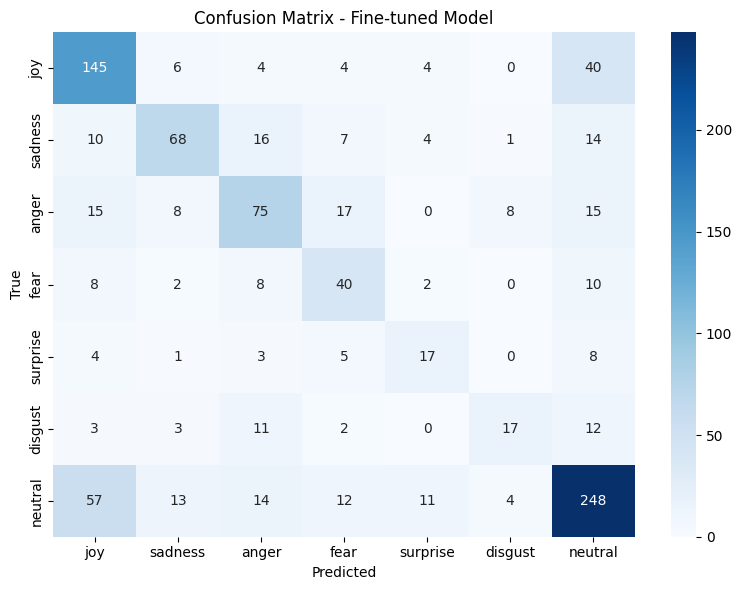

In [2]:
# --- EVALUATION OF THE FINE-TUNED MODEL ---

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions on the test set
preds = trainer.predict(tokenized_datasets["test"])
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

# Classification report
print("=== Classification Report ===")
print(classification_report(
    y_true, y_pred,
    target_names=[id2label[i] for i in range(len(label_list))],
    digits=3,
    zero_division=0
))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=[id2label[i] for i in range(len(label_list))],
            yticklabels=[id2label[i] for i in range(len(label_list))],
            cmap='Blues')
plt.title("Confusion Matrix - Fine-tuned Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

def extract_misclassifications(df_test, y_true, y_pred, id2label, top_n=10):
    """
    Extract false positives and false negatives per class.

    Args:
        df_test (pd.DataFrame): DataFrame with test data, must have 'verse' and 'verse_id'.
        y_true (np.array): True labels (ints).
        y_pred (np.array): Predicted labels (ints).
        id2label (dict): Mapping from label id to label name.
        top_n (int): Number of examples to extract per error type and class.

    Returns:
        dict: {class_label: {'false_positives': DataFrame, 'false_negatives': DataFrame}}
    """
    results = {}

    for label_id, label_name in id2label.items():
        # False positives: predicted as label but true label different
        fp_mask = (y_pred == label_id) & (y_true != label_id)
        fp_examples = df_test[fp_mask]
        fp_examples = fp_examples.assign(
            true_label=[id2label[t] for t in y_true[fp_mask]],
            predicted_label=label_name,
            error_type='false_positive'
        ).head(top_n)

        # False negatives: true label is label but predicted different
        fn_mask = (y_true == label_id) & (y_pred != label_id)
        fn_examples = df_test[fn_mask]
        fn_examples = fn_examples.assign(
            true_label=label_name,
            predicted_label=[id2label[p] for p in y_pred[fn_mask]],
            error_type='false_negative'
        ).head(top_n)

        results[label_name] = {
            'false_positives': fp_examples,
            'false_negatives': fn_examples
        }

    return results

# Example usage (after evaluation):

# df_test must contain at least the columns: 'verse', 'verse_id'
# y_true, y_pred are arrays with true and predicted labels (integers)
# id2label is a dictionary id -> class name

# Here we assume you already have these variables:
# df_test, y_true, y_pred, id2label

misclassified = extract_misclassifications(df_test, y_true, y_pred, id2label, top_n=10)

# To visualize, for example, false negatives of 'disgust':
print("=== False Negatives for 'disgust' ===")
print(misclassified['disgust']['false_negatives'][['verse_id', 'verse', 'true_label', 'predicted_label']])

# You can export to CSV for each class and error type:
for label, errors in misclassified.items():
    errors['false_positives'].to_csv(f"false_positives_{label}.csv", index=False)
    errors['false_negatives'].to_csv(f"false_negatives_{label}.csv", index=False)


=== False Negatives for 'disgust' ===
               verse_id                                              verse  \
8835         judges_9_4  And they gave him threescore and ten pieces of...   
8868      proverbs_23_2  And put a knife to thy throat, if thou be a ma...   
9074      psalms_116_11             I said in my haste, All men are liars.   
9118      1_kings_14_23  For they also built them high places, and imag...   
9176         isaiah_2_6  Therefore thou hast forsaken thy people the ho...   
9203  ecclesiastes_10_6  Folly is set in great dignity, and the rich si...   
9255     leviticus_1_15  And the priest shall bring it unto the altar, ...   
9273      proverbs_2_14  Who rejoice to do evil, and delight in the fro...   
9288    leviticus_14_37  And he shall look on the plague, and, behold, ...   
9299      jeremiah_4_30  And when thou art spoiled, what wilt thou do? ...   

     true_label predicted_label  
8835    disgust         neutral  
8868    disgust            fear  
9

# 7️⃣ Inference on New Verses and Comparison with Pretrained Models

## 6. Inference on New Verses

We apply the fine-tuned model to new, unseen verses and compare its outputs with those of the original pretrained models.


In [10]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Ruta al modelo fine-tuneado
MODEL_PATH = "../src/fine_tuning/finetuned-goemotions-bible-optuna"

# Carga tokenizer y modelo
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)

id2label = model.config.id2label
label_list = list(id2label.values())

# Nuevos versículos
new_verses = [
    "Jesus wept.",
    "Let there be light.",
    "The LORD is my shepherd; I shall not want.",
    "The serpent deceived me, and I ate.",
    "I'm happy because I passed my exam.",
    "I am happy because I passed the exam.",
    "Estoy feliz porque he aprobado el examen"
]

# Tokeniza
inputs = tokenizer(new_verses, truncation=True, padding=True, return_tensors="pt")
# Desactiva gradientes para inferencia
with torch.no_grad():
    outputs = model(**inputs)

probs = outputs.logits.softmax(dim=1).detach().numpy()

for i, verse in enumerate(new_verses):
    pred = id2label[np.argmax(probs[i])]
    print(f"Verse: {verse}\n  Predicted emotion: {pred}\n  Probabilities: {dict(zip(label_list, probs[i]))}\n")



Verse: Jesus wept.
  Predicted emotion: sadness
  Probabilities: {'joy': 0.004561873, 'sadness': 0.97205263, 'anger': 0.0055633504, 'fear': 0.008343148, 'surprise': 0.0033725249, 'disgust': 0.0031175292, 'neutral': 0.0029888048}

Verse: Let there be light.
  Predicted emotion: joy
  Probabilities: {'joy': 0.9586938, 'sadness': 0.0073417816, 'anger': 0.0024242406, 'fear': 0.0041760285, 'surprise': 0.00557628, 'disgust': 0.0017960677, 'neutral': 0.019991824}

Verse: The LORD is my shepherd; I shall not want.
  Predicted emotion: joy
  Probabilities: {'joy': 0.912757, 'sadness': 0.0027764987, 'anger': 0.003026264, 'fear': 0.0044029593, 'surprise': 0.0015323034, 'disgust': 0.0027971156, 'neutral': 0.072707854}

Verse: The serpent deceived me, and I ate.
  Predicted emotion: sadness
  Probabilities: {'joy': 0.0054140985, 'sadness': 0.6192336, 'anger': 0.060794577, 'fear': 0.16755758, 'surprise': 0.06050903, 'disgust': 0.07681333, 'neutral': 0.009677809}

Verse: I'm happy because I passed my

### **(Optional) Compare with old models**
- Load your previous model predictions for the same verses (Hartmann, GoEmotions, etc.) and print/plot differences.
- Qualitative analysis: Does the fine-tuned model better reflect the context and subtlety of the biblical style?


# 8️⃣ Conclusions

# Conclusions

- Pretrained emotion models struggle with literary/biblical text (neutral bias, poor fit).
- Fine-tuning SamLowe/roberta-base-go_emotions with a small, curated dataset dramatically improves performance.
- The new model aligns much better with human annotation and context.
- Further improvements could involve a larger dataset, multi-labeling, or expanding the taxonomy of emotions.

---

**Appendix:**  
- Full annotation prompt for GPT-4o:

```
Assign ONE main human emotion to each Bible verse below. 
Choose ONLY from this exact list (write just the emotion word in lowercase English, with NO explanations): 
joy, sadness, anger, fear, disgust, surprise, neutral

Return the results in CSV format with columns:
id,verse_id,label

Do not include the verse text in your answer. 
Use only the id and verse_id as shown, then your label. Do not add any extra columns, explanations, or blank lines.

EXAMPLE OUTPUT:
0,2_kings_1_10,anger
1,1_samuel_19_21,surprise
2,1_chronicles_21_21,neutral

VERSES:
0,2_kings_1_10,"And Elijah answered and said to the captain of fifty, If I be a man of God, then let fire come down from heaven, and consume thee and thy fifty. And there came down fire from heaven, and consumed him and his fifty."
1,1_samuel_19_21,"And when it was told Saul, he sent other messengers, and they prophesied likewise. And Saul sent messengers again the third time, and they prophesied also."
2,1_chronicles_21_21,"And as David came to Ornan, Ornan looked and saw David, and went out of the threshingfloor, and bowed himself to David with his face to the ground."
3,song_of_solomon_2_4,"He brought me to the banqueting house, and his banner over me was love."
4,hosea_4_4,"Yet let no man strive, nor reprove another: for thy people are as they that strive with the priest."
5,luke_13_7,"Then said he unto the dresser of his vineyard, Behold, these three years I come seeking fruit on this fig tree, and find none: cut it down; why cumbereth it the ground?"
6,leviticus_10_10,"And that ye may put difference between holy and unholy, and between unclean and clean;"
7,lamentations_1_1,"How doth the city sit solitary, that was full of people how is she become as a widow she that was great among the nations, and princess among the provinces, how is she become tributary"
8,jeremiah_42_3,"That the LORD thy God may shew us the way wherein we may walk, and the thing that we may do."
9,numbers_1_48,"For the LORD had spoken unto Moses, saying,"
```
- Data/statistics about annotation agreement  
- Example annotation errors and corrections

---
